In [ ]:
!nvidia-smi

Thu Jun  9 16:48:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q segmentation_models

     |████████████████████████████████| 50 kB 6.8 MB/s 


In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d ashish2001/multiclass-face-segmentation

!unzip -q /content/multiclass-face-segmentation.zip

Saving kaggle.json to kaggle.json
kaggle.json
100% 3.25G/3.26G [00:30<00:00, 156MB/s]
100% 3.26G/3.26G [00:30<00:00, 113MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from glob import glob
import matplotlib.pyplot as plt
import cv2 
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import keras

In [ ]:
print(tf.__version__)
print(keras.__version__)

2.8.2
2.8.0


In [ ]:
train_imgs = sorted(glob('./content/All_data/train/image/*'))
val_imgs = sorted(glob('./content/All_data/val/image/*'))
total_imgs = train_imgs + val_imgs
len(train_imgs), len(val_imgs), len(total_imgs)

(19535, 2653, 22188)

In [ ]:
total_imgs[19533:19538]

['./content/All_data/train/image/2090_0009.jpg',
 './content/All_data/train/image/2090_0010.jpg',
 './content/All_data/val/image/0015_0001.jpg',
 './content/All_data/val/image/0015_0002.jpg',
 './content/All_data/val/image/0015_0003.jpg']

In [ ]:
train_masks = sorted(glob('./content/All_data/train/seg/*'))
val_masks = sorted(glob('./content/All_data/val/seg/*'))
total_masks = train_masks + val_masks
len(train_masks), len(val_masks), len(total_masks)

(19535, 2653, 22188)

In [ ]:
total_masks[19533:19538]

['./content/All_data/train/seg/2090_0009.png',
 './content/All_data/train/seg/2090_0010.png',
 './content/All_data/val/seg/0015_0001.png',
 './content/All_data/val/seg/0015_0002.png',
 './content/All_data/val/seg/0015_0003.png']

In [ ]:
d = {}

for i in tqdm(total_masks):
  img = cv2.imread(i,0)
  img = cv2.resize(img, (256, 256), fx=0, fy=0, interpolation=cv2.INTER_NEAREST)

  img = np.where(img== 3, 2, img) # eyebrow
  img = np.where(img== 14, 13, img) # ear
  for j in [9, 8]:
      img = np.where(img== j, 7, img) # mouth
  img = np.where(img== 5, 4, img) # eye
  for j in [11, 12]:
      img = np.where(img== j, 1, img) # skin
  for j in [10, 15, 17]:
      img = np.where(img== j, 0, img) # background

  # print(np.unique(img))
  # break
  cv2.imwrite(i, img)

  for j in np.unique(img):
    if j in d.keys():
      d[j] += 1
    else:
      d[j] = 0

100%|██████████| 22188/22188 [03:54<00:00, 94.63it/s]


In [ ]:
d

{0: 22187,
 1: 22182,
 2: 21610,
 4: 21335,
 6: 22004,
 7: 21639,
 13: 17640,
 16: 3789}

In [ ]:
# 0: background
# 1: face skin
# 2: eyebrow
# 4: eye
# 6: nose
# 7: mouth
# 13: ear
# 16: glasses

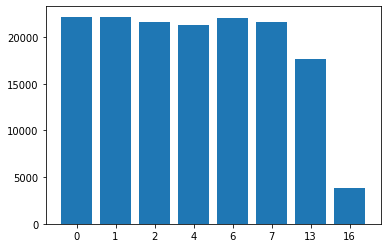

In [ ]:
names = list(d.keys())
values = list(d.values())

plt.bar(range(len(d)), values, tick_label=names)
plt.show()

In [ ]:
import os
import numpy as np
import cv2
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf

def load_dataset(images, masks):
    
    train_x, test_x, train_y, test_y = train_test_split(images, masks, test_size=0.35, random_state=1996, shuffle=True)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=1996, shuffle=True)
    
    return train_x, val_x, train_y, val_y, test_x, test_y

train_x, val_x, train_y, val_y, test_x, test_y = load_dataset(sorted(total_imgs), sorted(total_masks))
train_x, val_x, train_y, val_y = train_x[:4000], val_x[:800], train_y[:4000], val_y[:800]
print(len(train_x), len(val_x), len(train_y), len(val_y), len(test_x), len(test_y))

train_X_y_paths = list(zip(train_x, train_y))
val_X_y_paths = list(zip(test_x, test_y))
test_X_y_paths = list(zip(val_x, val_y))

def get_data_generator(samples,batch_size):

  while True:

    for offset in range(0, len(samples), batch_size): 
      batch_samples = samples[offset:offset+batch_size]
      X_train = []
      Y_train = []        
 
      for batch_sample in batch_samples:
        X_image = cv2.imread(batch_sample[0])[:,:,::-1]
        X_image = cv2.resize(X_image, (256, 256))
        X_image = X_image / 255.0
        X_image = X_image.astype(np.float32)

        Y_image = cv2.imread(batch_sample[1], 0)
        Y_image = tf.one_hot(Y_image, 8, dtype = np.float32)

        X_train.append(X_image)
        Y_train.append(Y_image)
 
      yield np.array(X_train), np.array(Y_train)


BATCH_SIZE = 32
train_generator = get_data_generator(train_X_y_paths,batch_size=BATCH_SIZE)
val_generator = get_data_generator(val_X_y_paths,batch_size=BATCH_SIZE)
test_generator = get_data_generator(test_X_y_paths,batch_size=BATCH_SIZE)

x_train, y_train = next(train_generator)
x_val, y_val  = next(val_generator)
x_test, y_test  = next(test_generator)

print(x_train.shape,y_train.shape)
print(x_val.shape, y_val.shape)
print(x_test.shape, y_test.shape)

4000 800 4000 800 7766 7766
(32, 256, 256, 3) (32, 256, 256, 8)
(32, 256, 256, 3) (32, 256, 256, 8)
(32, 256, 256, 3) (32, 256, 256, 8)


In [ ]:
np.unique(next(train_generator)[1])

array([0., 1.], dtype=float32)

In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
%env SM_FRAMEWORK=tf.keras

import numpy as np
import tensorflow as tf
from keras import backend as K 
from segmentation_models.losses import cce_jaccard_loss, dice_loss, JaccardLoss
from segmentation_models.metrics import iou_score, f1_score, precision, recall
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from DeepLabV3 import DeepLabV3Plus
from PSPNet import PSPNet


""" Paramaters """
input_shape = (256, 256, 3)
epochs = 1000
lr = 1e-1
csv_path = "/content/drive/MyDrive/SE_Test/history.csv"
model_name = 'DeepLabV3Plus'
n_classes = 8


""" callbacks """
checkpoint_filepath = '/content/drive/MyDrive/SE_Test/Face_Seg_00{epoch}.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_iou_score',
    mode='max',
    verbose = 1,
    period = 3,
    save_best_only=False
    )

callbacks = [
    model_checkpoint_callback,
    ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5, verbose=1),
    CSVLogger(csv_path),
    EarlyStopping(monitor="val_loss", patience=10)
]


""" steps per epochs """
train_steps = len(train_x)//BATCH_SIZE
if len(train_x) % BATCH_SIZE != 0:
    train_steps += 1

val_steps = len(val_x)//BATCH_SIZE
if len(val_x) % BATCH_SIZE != 0:
    val_steps += 1

print(train_steps, val_steps)


""" Model training """
ls = dice_loss + cce_jaccard_loss
metrics = [precision, recall, f1_score, iou_score] 

K.clear_session()
if model_name == 'DeepLabV3Plus': 
  model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
elif model_name == 'PSPNet': 
  model = DeepLabV3Plus(inputs=input_shape, classes=n_classes)
# model.summary()

model.compile(
    loss=ls,
    optimizer=tf.keras.optimizers.SGD(learning_rate=lr),
    metrics=metrics
)

h = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    steps_per_epoch=train_steps,
    validation_steps=val_steps,
    callbacks=callbacks,
    batch_size=BATCH_SIZE,
)

env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.
125 25
16719872/16705208 [==============================] - 0s 0us/step
Epoch 1/1000
125/125 [==============================] - 280s 2s/step - loss: 1.5107 - precision: 0.2943 - recall: 0.5862 - f1-score: 0.2989 - iou_score: 0.2352 - val_loss: 2.1579 - val_precision: 0.1344 - val_recall: 0.4113 - val_f1-score: 0.0865 - val_iou_score: 0.0532 - lr: 0.1000
Epoch 2/1000
125/125 [==============================] - 247s 2s/step - loss: 1.0603 - precision: 0.5250 - recall: 0.7924 - f1-score: 0.5271 - iou_score: 0.4277 - val_loss: 2.5164 - val_precision: 0.1412 - val_recall: 0.4042 - val_f1-score: 0.0777 - val_iou_score: 0.0463 - lr: 0.1000
Epoch 3/1000
125/125 [==============================] - ETA: 0s - loss: 0.9532 - precision: 0.5818 - recall: 0.8285 - f1-score: 0.5768 - iou_score: 0.4827
Epoch 3: saving model to /content/drive/MyDrive/SE_Test/Face_Seg_003.h5
125/125 [==============================] - 249s 2s/step -

dict_keys(['loss', 'precision', 'recall', 'f1-score', 'iou_score', 'val_loss', 'val_precision', 'val_recall', 'val_f1-score', 'val_iou_score', 'lr']) 



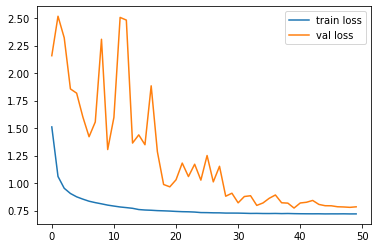

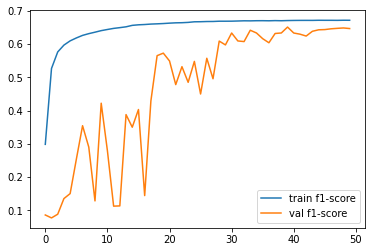

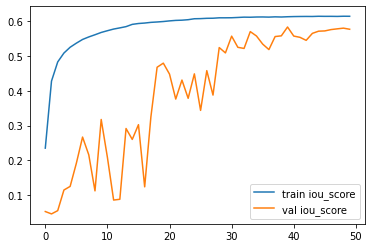

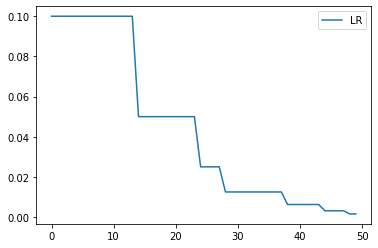

In [ ]:
print(h.history.keys(),"\n")

import matplotlib.pyplot as plt

plt.plot(h.history['loss'], label='train loss')
plt.plot(h.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(h.history['f1-score'], label='train f1-score')
plt.plot(h.history['val_f1-score'], label='val f1-score')
plt.legend()
plt.show()

plt.plot(h.history['iou_score'], label='train iou_score')
plt.plot(h.history['val_iou_score'], label='val iou_score')
plt.legend()
plt.show()

plt.plot(h.history['lr'], label='LR')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/SE_Test/Face_last.h5')

In [ ]:
test_steps = len(test_x)//BATCH_SIZE
if len(test_x) % BATCH_SIZE != 0:
    test_steps += 1
    
print(test_steps)    

model.evaluate(test_generator, batch_size=BATCH_SIZE, steps=test_steps, workers=-1, use_multiprocessing=True)

243
243/243 [==============================] - 328s 1s/step - loss: 0.7774 - precision: 0.6583 - recall: 0.8928 - f1-score: 0.6501 - iou_score: 0.5808


[0.7774321436882019,
 0.6583102941513062,
 0.8928269147872925,
 0.6500921845436096,
 0.5807873010635376]

In [ ]:
test_x[100], test_y[100]

('./content/All_data/val/image/1162_0002.jpg',
 './content/All_data/val/seg/1162_0002.png')

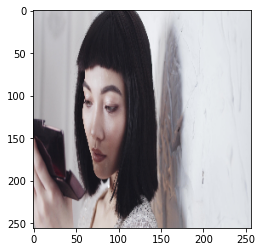

In [ ]:
img = cv2.imread(test_x[100])[:,:,::-1]
img = cv2.resize(img, (256,256))
plt.imshow(img)
plt.show()
img = img/255.0

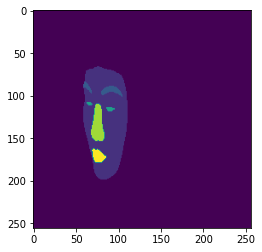

In [ ]:
mask = cv2.imread(test_y[100],0)
plt.imshow(mask)
plt.show()

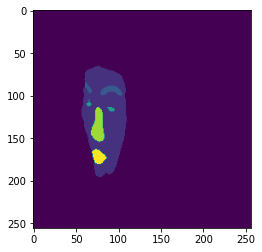

In [ ]:
pred = model.predict(img.reshape(1, 256, 256, 3))
pred = np.argmax(pred, axis = 3)
plt.imshow(pred.reshape(256, 256))
plt.show()

In [ ]:
test_x[10], test_y[10]

('./content/All_data/train/image/1359_0003.jpg',
 './content/All_data/train/seg/1359_0003.png')

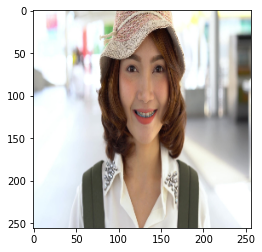

In [ ]:
img = cv2.imread(test_x[10])[:,:,::-1]
img = cv2.resize(img, (256,256))
plt.imshow(img)
plt.show()
img = img/255.0

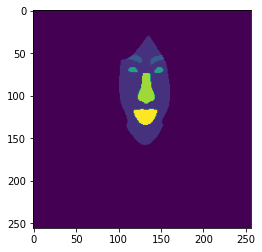

In [ ]:
mask = cv2.imread(test_y[10],0)
plt.imshow(mask)
plt.show()

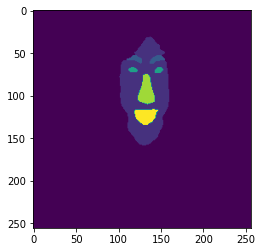

In [ ]:
pred = model.predict(img.reshape(1, 256, 256, 3))
pred = np.argmax(pred, axis = 3)
plt.imshow(pred.reshape(256, 256))
plt.show()

In [ ]:
test_x[50], test_y[50]

('./content/All_data/train/image/1209_0015.jpg',
 './content/All_data/train/seg/1209_0015.png')

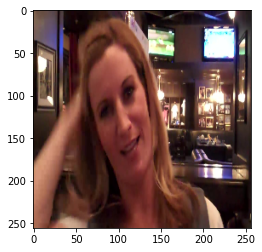

In [ ]:
img = cv2.imread(test_x[50])[:,:,::-1]
img = cv2.resize(img, (256,256))
plt.imshow(img)
plt.show()
img = img/255.0

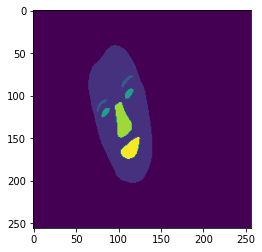

In [ ]:
mask = cv2.imread(test_y[50],0)
plt.imshow(mask)
plt.show()

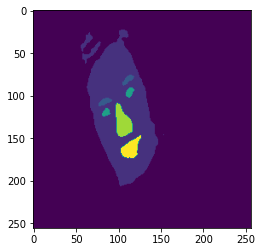

In [ ]:
pred = model.predict(img.reshape(1, 256, 256, 3))
pred = np.argmax(pred, axis = 3)
plt.imshow(pred.reshape(256, 256))
plt.show()